# Ingredient-Based Clustering of Pinoy Dishes

The ambition is to identify clusters of Filipino dishes based on their ingredients. The results can be used to define the most common ingredients of a Filipino pantry. This project leverages techniques from data mining, natural language processing, and unsupervised learning. The dataset is a collection of Filipino recipes from various online recipe websites. The dataset contains the name, ingredients, and instructions of the recipes. 

## Data loading and preview

In [1]:
import json
import os

import pandas as pd


def merge_recipe_data(path="data"):
    """Combines all recipe data into a single list."""
    recipe_files = [
        file for file in os.listdir(path) if file.endswith("recipes.json")
    ]

    recipes = []
    for file in recipe_files:
        file_path = os.path.join(path, file)
        with open(file_path, encoding="utf-8") as f:
            recipe_data = json.load(f)
            recipes.extend(recipe_data)

    return recipes


recipes = merge_recipe_data()
recipe_df = pd.DataFrame(recipes)
recipe_df.head()

,link,name,ingredients,instructions
0,https://www.kawalingpinoy.com/cheese-cupcakes/,Cheese Cupcakes,"[flour, sifted, baking powder, salt, butter, s...","[Line muffin pan with cupcake liners., In a la..."
1,https://www.kawalingpinoy.com/adobong-sitaw-wi...,Adobong Sitaw with Pork,"[canola oil, pork belly, cut into thin strips,...","[In a skillet over medium heat, heat oil. Add ..."
2,https://www.kawalingpinoy.com/burger-steak/,Burger Steak,"[white bread, torn into small pieces, beef bro...","[In a small bowl, soak bread in broth. Tear wi..."
3,https://www.kawalingpinoy.com/chicken-menudo/,Chicken Menudo,"[canola oil, red bell pepper, cored, seeded an...","[In a wide pan over medium heat, heat 1 tables..."
4,https://www.kawalingpinoy.com/beef-salpicao/,Beef Salpicao,"[ribeye steak, cut into 1-inch cubes, salt and...","[In a bowl, season beef with salt and pepper t..."


In [2]:
recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2815 entries, 0 to 2814
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   link          2815 non-null   object
 1   name          2469 non-null   object
 2   ingredients   2469 non-null   object
 3   instructions  2469 non-null   object
dtypes: object(4)
memory usage: 88.1+ KB


### Discover patterns through visualization

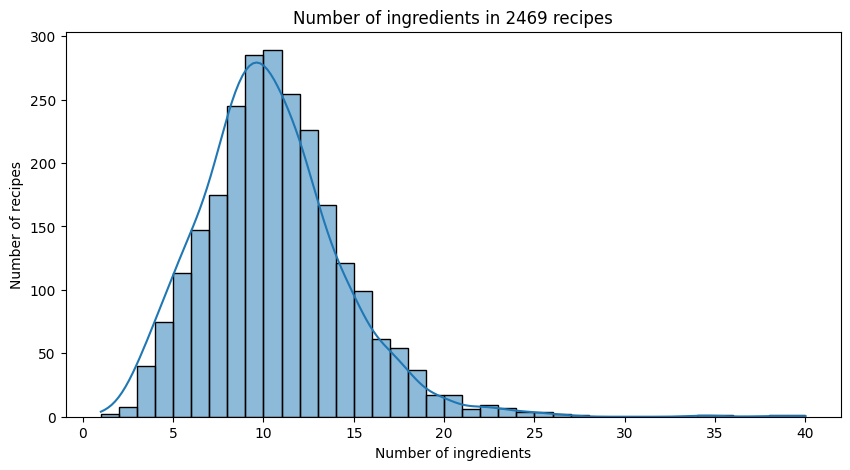

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

def plot_ingredient_counts(df, colname="ingredients"):
    """Plots the distribution of ingredient counts in a Pandas DataFrame."""

    ingredient_counts = df[colname].dropna().apply(len)

    plt.figure(figsize=(10, 5))
    sns.histplot(ingredient_counts, kde=True, binwidth=1)
    plt.title(f"Number of ingredients in {len(ingredient_counts)} recipes")
    plt.xlabel("Number of ingredients")
    plt.ylabel("Number of recipes")
    plt.show()

plot_ingredient_counts(recipe_df)

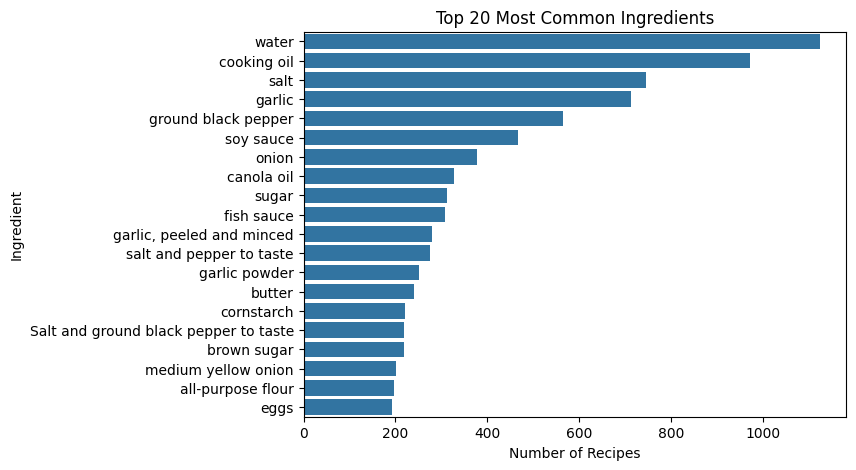

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_ingredient_frequencies(df, n=20, most_common=True, figsize=(7, 5), colname="ingredients"):
    """Displays a bar plot of the most or least frequent ingredients."""

    all_ingredients = df[colname].dropna().explode()
    ingredient_counts = all_ingredients.value_counts()

    if most_common:
        top_n_ingredients = ingredient_counts.head(n)
    else:
        top_n_ingredients = ingredient_counts.tail(n)

    plt.figure(figsize=figsize)
    sns.barplot(
        x=top_n_ingredients.values,
        y=top_n_ingredients.index,
    )

    title = f"Top {n} {'Most' if most_common else 'Least'} Common Ingredients"
    plt.title(title)
    plt.xlabel("Number of Recipes")
    plt.ylabel("Ingredient")
    plt.show()


plot_ingredient_frequencies(recipe_df)

### Save the all unique ingredients in a file

In [5]:
def save_ingredients(df, path, colname="ingredients"):
    unique_ingredients = (
        df[colname].dropna().explode().unique().astype(str)
    )
    unique_ingredients.sort()

    with open(path, "w", encoding="utf-8") as file:
        file.writelines("\n".join(unique_ingredients))


save_ingredients(recipe_df, "data/unique_raw_ingredients.txt")

## Preprocessing


### Remove recipes without ingredients

In [6]:
recipe_df = recipe_df.dropna(subset=["ingredients", "name"])
recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2469 entries, 0 to 2814
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   link          2469 non-null   object
 1   name          2469 non-null   object
 2   ingredients   2469 non-null   object
 3   instructions  2469 non-null   object
dtypes: object(4)
memory usage: 96.4+ KB


### Tokenize

In [7]:
import spacy
from tabulate import tabulate

nlp = spacy.load("en_core_web_lg")


def display_tokens(text):
    """Display token attributes for a given string.""",
    rows = []
    for token in nlp(text):
        row = [
            token.text,
            token.lemma_,
            token.pos_,
            token.tag_,
            token.dep_,
            token.is_alpha,
        ]
        rows.append(row)
    headers = ["text", "lemma", "pos", "tag", "dep", "is_alpha"]
    print(tabulate(rows, headers=headers))


SAMPLE_INGREDIENT = "small lemons or 6 to 7 pieces calamansi"
display_tokens(SAMPLE_INGREDIENT)

text       lemma      pos    tag    dep       is_alpha
---------  ---------  -----  -----  --------  ----------
small      small      ADJ    JJ     amod      True
lemons     lemon      NOUN   NNS    ROOT      True
or         or         CCONJ  CC     cc        True
6          6          NUM    CD     quantmod  False
to         to         PART   TO     quantmod  True
7          7          NUM    CD     nummod    False
pieces     piece      NOUN   NNS    conj      True
calamansi  calamansi  PROPN  NNP    appos     True


### Lemmatize and remove non-ingredient words

In [8]:
def lemmatize_valid_nouns(ingredient):
    """Lemmatize valid nouns in a string.""",
    doc = nlp(ingredient)
    valid_lemmas = []
    for token in doc:
        if (
            token.is_alpha
            and not token.is_stop
            and token.pos_ in ["NOUN", "PROPN"]
        ):
            valid_lemmas.append(token.lemma_)
    return " ".join(valid_lemmas)


lemmatized = lemmatize_valid_nouns(SAMPLE_INGREDIENT)
display_tokens(lemmatized)

text       lemma      pos    tag    dep       is_alpha
---------  ---------  -----  -----  --------  ----------
lemon      lemon      NOUN   NN     compound  True
piece      piece      NOUN   NN     compound  True
calamansi  calamansi  NOUN   NN     ROOT      True


### Remove culinary stop words

In [9]:
with open(f"data/culinary_stopwords.txt") as file:
    stopwords = [line.strip() for line in file]


def filter_stopwords(text):
    """Filter out stopwords from a string."""
    meaningful_terms = []
    for term in text.split():
        if term not in stopwords:
            meaningful_terms.append(term)
    return " ".join(meaningful_terms)


filtered = filter_stopwords(lemmatized)
display_tokens(filtered)

text       lemma      pos    tag    dep       is_alpha
---------  ---------  -----  -----  --------  ----------
lemon      lemon      NOUN   NN     compound  True
calamansi  calamansi  PROPN  NNP    ROOT      True


### Remove duplicate terms

In [10]:
def remove_duplicates(text):
    """Remove duplicate terms while preserving order."""
    seen = set()
    unique = []
    for ingredient in text.split():
        if ingredient not in seen:
            unique.append(ingredient)
            seen.add(ingredient)
    return " ".join(unique)

unique = remove_duplicates(filtered)
display_tokens(unique)

text       lemma      pos    tag    dep       is_alpha
---------  ---------  -----  -----  --------  ----------
lemon      lemon      NOUN   NN     compound  True
calamansi  calamansi  PROPN  NNP    ROOT      True


### Handle synonyms to standardize ingredients

In [11]:
with open("data/phrase_synonyms.json") as file:
    phrase_synonyms = json.load(file)


def handle_phrase_synonyms(ingredient):
    """Replace ingredient synonyms with a common name."""
    return phrase_synonyms.get(ingredient, ingredient)

common_name = handle_phrase_synonyms(unique)
display_tokens(common_name)

text       lemma      pos    tag    dep       is_alpha
---------  ---------  -----  -----  --------  ----------
lemon      lemon      NOUN   NN     compound  True
calamansi  calamansi  PROPN  NNP    ROOT      True


In [ ]:
with open("data/word_synonyms.json") as file:
    word_synonyms = json.load(file)


def handle_word_synonyms(ingredient):
    """Replace ingredient synonyms with a common name."""
    common_words = []
    for word in ingredient.split():
        common_words.append(word_synonyms.get(word, word))
    return " ".join(common_words)

### Define the entire preprocessing pipeline

In [12]:
import re


def preprocess_ingredient(ingredient):
    """Preprocess an ingredient string to extract key terms.""",
    no_parenthesis = re.sub(r"\([^)]*\)", "", ingredient)
    first_option = no_parenthesis.split(" or ")[0]
    formatted = first_option.lower().strip()

    lemmatized = lemmatize_valid_nouns(formatted)
    filtered = filter_stopwords(lemmatized)
    word_synonym = handle_word_synonyms(filtered)
    unique = remove_duplicates(word_synonym)
    phrase_synonym = handle_phrase_synonyms(unique)

    return phrase_synonym


clean_ingredient = preprocess_ingredient(SAMPLE_INGREDIENT)
clean_ingredient

'lemon'

### Apply the preprocessing pipeline

In [13]:
from tqdm.auto import tqdm


def clean_ingredients(ingredients):
    """Applies preprocessing to a list of ingredients."""
    cleaned_ingredients = [
        preprocess_ingredient(ingredient) for ingredient in ingredients
    ]
    return list(sorted(set(filter(None, cleaned_ingredients))))


tqdm.pandas()

recipe_df["cleaned_ingredients"] = (
    recipe_df["ingredients"].progress_apply(clean_ingredients)
)

  0%|          | 0/2469 [00:00<?, ?it/s]

In [14]:
save_ingredients(
    recipe_df,
    "data/unique_cleaned_ingredients.txt",
    colname="cleaned_ingredients",
)

In [15]:
unique_cleaned_ingredients = (
    recipe_df["cleaned_ingredients"].explode().unique().astype(str)
)

with open("data/ingredient_synonyms.json") as file:
    phrase_synonyms = json.load(file)

# Remove entries in synonyms that are not in the cleaned ingredients
phrase_synonyms = {
    key: value
    for key, value in phrase_synonyms.items()
    if key in unique_cleaned_ingredients
}

with open("data/ingredient_synonyms.json", "w") as file:
    json.dump(phrase_synonyms, file, indent=2)

In [16]:
recipe_df[["ingredients", "cleaned_ingredients"]].to_json(
    "data/recipes_with_cleaned_ingredients.json",
    orient="records",
)

### Visualize cleaned ingredients

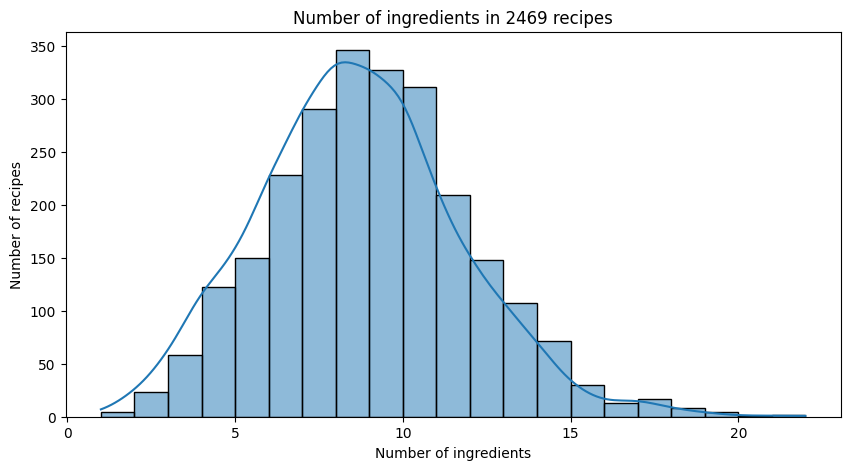

In [17]:
plot_ingredient_counts(recipe_df, colname="cleaned_ingredients")

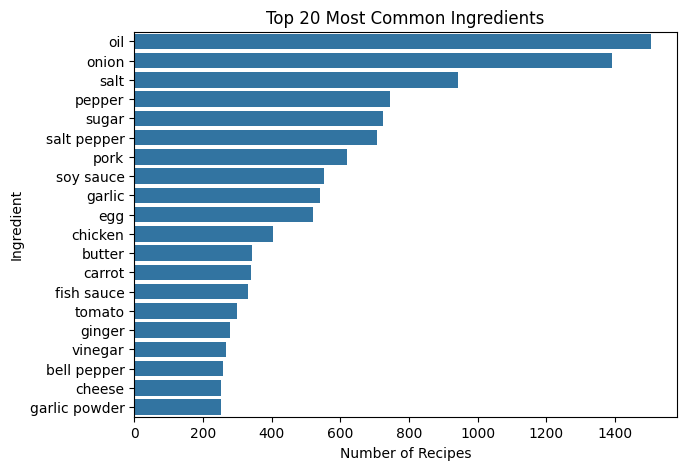

In [18]:
plot_ingredient_frequencies(recipe_df, colname="cleaned_ingredients")

### Remove recipes rare ingredients

In [19]:
ingredient_counts = recipe_df["cleaned_ingredients"].explode().value_counts()
rare_ingredients = ingredient_counts[ingredient_counts <= 5].index

with open("data/rare_ingredients.txt", "w", encoding="utf-8") as file:
    file.writelines("\n".join(sorted(rare_ingredients)))

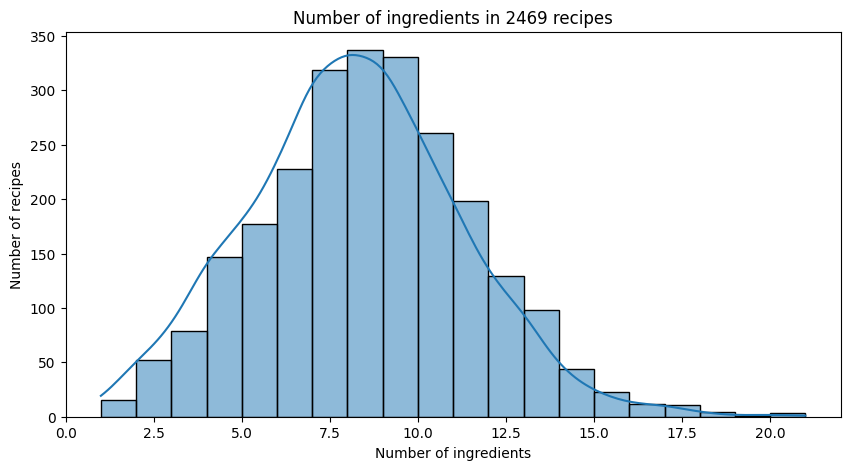

In [20]:
def remove_rare_ingredients(ingredients):
    """Remove rare ingredients from a list."""
    return [
        ingredient
        for ingredient in ingredients
        if ingredient not in rare_ingredients
    ]

reduced_df = recipe_df.copy()

reduced_df.loc[:, "cleaned_ingredients"] = (
    reduced_df["cleaned_ingredients"].apply(remove_rare_ingredients)
)

plot_ingredient_counts(reduced_df, colname="cleaned_ingredients")

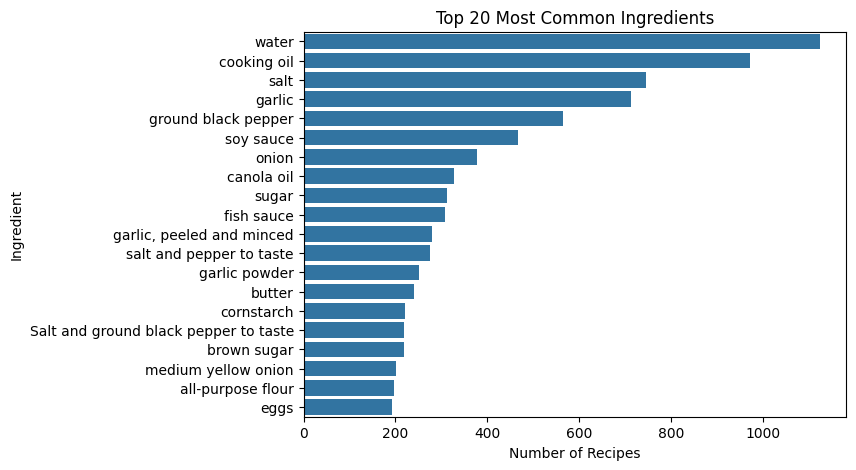

In [21]:
plot_ingredient_frequencies(reduced_df, colname="cleaned_ingredients")

### Remove recipes with very few ingredients

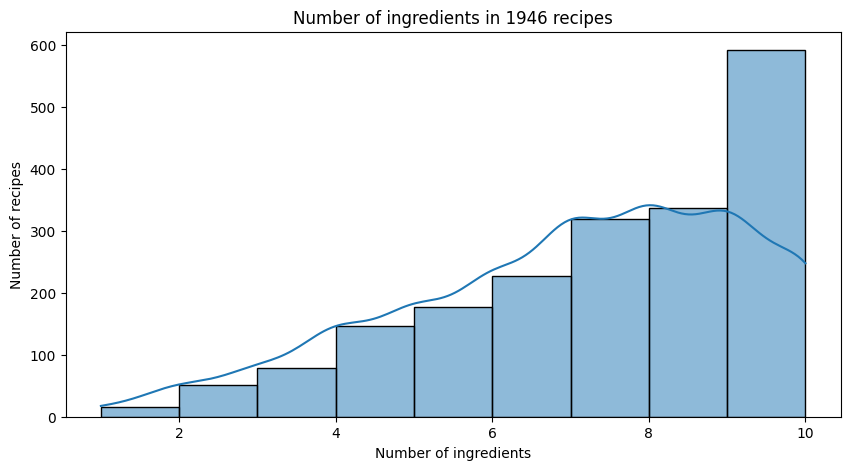

In [22]:
ingredient_counts = reduced_df["cleaned_ingredients"].apply(len)
q1 = ingredient_counts.quantile(0.75)
reduced_df = reduced_df[ingredient_counts <= q1]

plot_ingredient_counts(reduced_df, colname="cleaned_ingredients")

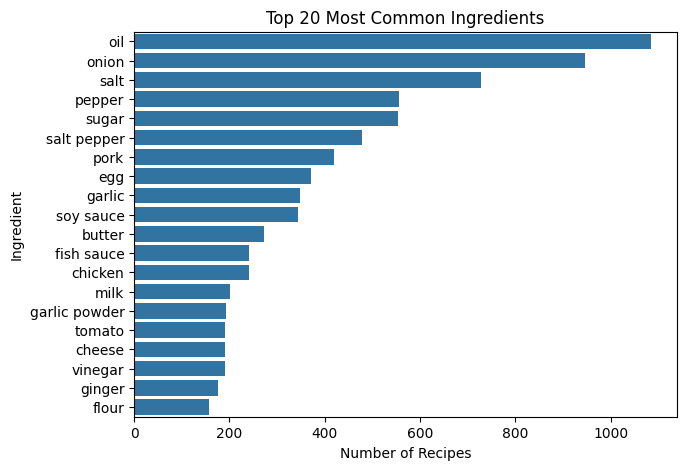

In [23]:
plot_ingredient_frequencies(reduced_df, colname="cleaned_ingredients")

## Vectorization


In [24]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(
    [" ".join(sorted(ingredients)) for ingredients in reduced_df["ingredients"]],
    show_progress_bar=True,
)

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

In [25]:
embeddings.shape

(1946, 768)

## Dimensionality reduction

In [26]:
from sklearn.decomposition import TruncatedSVD

dimensions_to_keep = 2
svd = TruncatedSVD(n_components=dimensions_to_keep)
reduced_embeddings = svd.fit_transform(embeddings)

## Clustering


In [27]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 7
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
cluster_labels = clustering.fit_predict(reduced_embeddings)

## Visualization


In [30]:
import plotly.express as px
import pandas as pd

recipe_df = pd.DataFrame(
    {
        "x": reduced_embeddings[:, 0],
        "y": reduced_embeddings[:, 1],
        "cluster": cluster_labels.astype(str),
        "recipe_name": reduced_df["name"],
        "cleaned_ingredients": [
            "<br>".join(ingredients)
            for ingredients in reduced_df["cleaned_ingredients"]
        ],
    }
)

fig = px.scatter(
    recipe_df,
    x="x",
    y="y",
    color="cluster",
    hover_name="recipe_name",
    hover_data=["cleaned_ingredients"],
    width=750,
    height=750,
    color_discrete_sequence=px.colors.qualitative.Bold,
)

fig.update_traces(marker=dict(size=5))
fig.update_layout(title="Ingredient-Based Clustering of Filipino Dishes")

unique_clusters = recipe_df["cluster"].unique()
buttons = list(
    [
        dict(
            label=f"Cluster {cluster}",
            method="update",
            args=[
                {"visible": [cluster == c for c in unique_clusters]},
                {"title": f"Ingredient-Based Clustering - Cluster {cluster}"},
            ],
        )
        for cluster in unique_clusters
    ]
)
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="down",
            buttons=buttons,
        )
    ]
)

fig.show()